In [ ]:
# %%capture --no-stderr
#%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
#%pip install openai langchain

In [3]:
#%pip install --upgrade openai langchain

   ---------------------------------------- 0.0/335.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/335.9 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/335.9 kB 495.5 kB/s eta 0:00:01
   ---------------------------- ----------- 235.5/335.9 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 335.9/335.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.35.10
    Uninstalling openai-1.35.10:
      Successfully uninstalled openai-1.35.10
Note: you may need to restart the kernel to use updated packages.


In [12]:
import getpass
import os
from langchain_openai import ChatOpenAI
from typing import List

from langchain_core.messages import SystemMessage
from langchain_core.pydantic_v1 import BaseModel

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [21]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [13]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [14]:
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages


class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]


llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

chain = get_messages_info | llm_with_tool

In [15]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# New system prompt
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""


# Function to get the messages for the prompt
# Will only get messages AFTER the tool call
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs


prompt_gen_chain = get_prompt_messages | llm

In [4]:
#def chatbot(state: State):
    #return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
#graph_builder.add_node("chatbot", chatbot)

In [5]:
#graph_builder.add_edge(START, "chatbot")

In [6]:
#graph_builder.add_edge("chatbot", END)

In [7]:
#graph = graph_builder.compile()

In [16]:
from typing import Literal

from langgraph.graph import END


def get_state(messages) -> Literal["add_tool_message", "info", "__end__"]:
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [17]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessageGraph

memory = MemorySaver()
workflow = MessageGraph()
workflow.add_node("info", chain)
workflow.add_node("prompt", prompt_gen_chain)


@workflow.add_node
def add_tool_message(state: list):
    return ToolMessage(
        content="Prompt generated!", tool_call_id=state[-1].tool_calls[0]["id"]
    )


workflow.add_conditional_edges("info", get_state)
workflow.add_edge("add_tool_message", "prompt")
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")
graph = workflow.compile(checkpointer=memory)

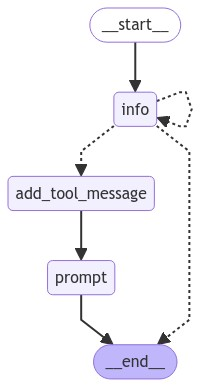

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
            [HumanMessage(content=user)], config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

Hi Tracy! I'd be happy to help you create a prompt template. To get started, could you please provide some details?

1. What is the objective of the prompt?
2. What variables will be passed into the prompt template?
3. Are there any constraints for what the output should NOT do?
4. Are there any requirements that the output MUST adhere to?

Feel free to provide as much detail as possible!
================================== Ai Message ==================================

It sounds like you might have some specific ideas in mind. Could you please clarify the following details for me?

1. What is the objective of the prompt? (e.g., generating a story, answering a question, summarizing text, etc.)
2. What variables will be passed into the prompt template? (e.g., names, dates, topics, etc.)
3. Are there any constraints for what the output should NOT do? (e.g., avoid certain topics, not exceed a certain length, 

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: It looks like you might be referring to a term or a concept that isn't fully clear. "Jason ID" could mean different things depending on the context. Here are a few possibilities:

1. **Jason-1 Satellite**: Jason-1 was a satellite mission jointly operated by NASA and the French space agency CNES. If you're looking for information related to Jason-1, such as its mission ID or specific data, that would be more context-specific.

2. **Jason Group**: The JASON Defense Advisory Group, often simply referred to as "JASON," is a group of elite scientists that advise the U.S. government on matters of science and technology. An "ID" in this context might refer to a document or identification related to the group.

3. **Personal Identification**: If you’re referring to a person named Jason and asking about some form of identification, that would be a very different and much more personal context.

4. **Software or Database ID**: In some soft